시계열 테이터로 설득하는 법

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #시각화
from matplotlib import dates # 시계열 데이터 다루기 위함
import statsmodels.api as sm # 회귀분석

In [15]:
df = pd.read_csv('LGSS.csv')
df.columns = ['date', 'lg', 'samsung']
df['date'] = pd.to_datetime(df['date'])
# print(type(df['date'][0]))
df.head(2)

,date,lg,samsung
0,2019-01-01,23,60
1,2019-01-02,31,73


# 탐색적 분석

<AxesSubplot:xlabel='date'>

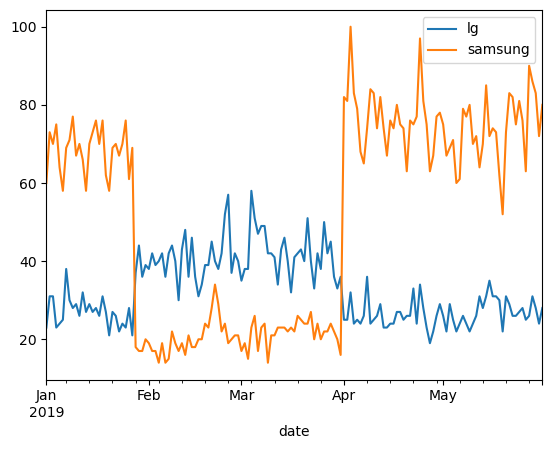

In [16]:
df.plot(x = 'date', y = ['lg', 'samsung'])
# 시계열 분석의 경우 이전 시간의 데이터를 참조한다. 
# 회귀의 경우 이전년도 이번 시간의 데이터를 참조한다.

# 추세만 넣어서 보기

const    32.974904
x1        0.243778
dtype: float64


<AxesSubplot:xlabel='date'>

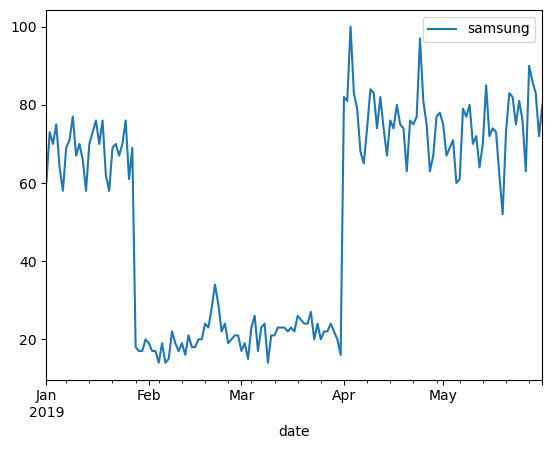

In [17]:
x = range(len(df["date"]))
y = df['samsung']

# 계수구하기
x = sm.add_constant(x)
model = sm.OLS(y, x)
result = model.fit()
print(result.params)
y_const, slope_samsung = result.params

# 그래프 그리기
df['prediction'] = [slope_samsung*value + y_const for value in x] 
df.head(2)
df.plot(x = 'date', y = ['samsung','prediction'])

## 일반회귀 분석

### 회귀분석을 위한 y절편, 기울기 구하기

const    32.974904
x1        0.243778
dtype: float64
595.6759698905172


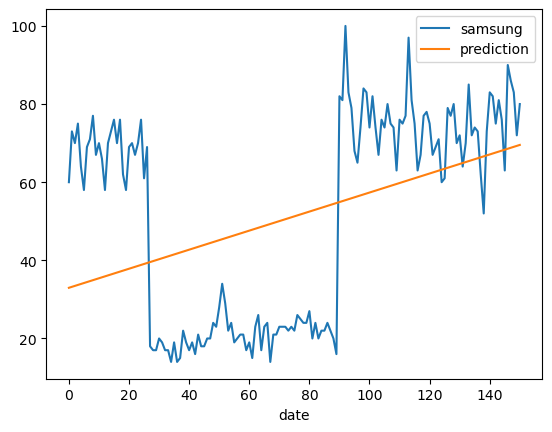

In [18]:
x = range(len(df['date']))
y = df['samsung']

x = sm.add_constant(x) # 시계열분석을 할 떄, 기울기(베타와 에이)를 도출하는 것이 목표지만
# 회귀에서는 y절편도 뽑아야 함 
model = sm.OLS(y, x) # odinary least 
result = model.fit()
a, b = result.params
print(result.params)

# 더 빠른 계산을 위한 코드
df1 = df.copy()
df1['date'] =  range(len(df1))
df1['prediction'] = df1['date'].apply(lambda x : b*x+a)
df1.head(2)

df1.plot(x = 'date', y = ['samsung','prediction'])

mse = [(click-df1['prediction'][num])**2 
       for num, click in enumerate(df1['samsung'])]
# 실제값고 예측값의 차이를 제곱한 mse의 값을 리스트화 함
print(np.mean(mse))

## interruption 전, 후 데이터 합쳐서 그래프그리기

In [19]:
df['samsung'][25:] #27(18)
df['samsung'][88:] #89(16)

88      20
89      16
90      82
91      81
92     100
      ... 
146     90
147     86
148     83
149     72
150     80
Name: samsung, Length: 63, dtype: int64

In [20]:
# 레벨체인지 없는 df만들기
left = df.iloc[:27, :3]
right = df.iloc[90:, :3]
bwn = df.iloc[27:90, :3]

no_interrupt = pd.concat([left, right], axis=0)
no_interrupt.head(2)

,date,lg,samsung
0,2019-01-01,23,60
1,2019-01-02,31,73


In [21]:
# x = range(len(left))
x = no_interrupt.index
y = no_interrupt['samsung']

x = sm.add_constant(x) 
model = sm.OLS(y, x)  
result = model.fit()
y_nointer, slope_nointer = result.params
print(result.params)

no_interrupt['trend'] =  range(len(no_interrupt))
no_interrupt['prediction'] = no_interrupt['trend'].apply(lambda x : slope_nointer*x + y_nointer)

const    68.427246
x1        0.052718
dtype: float64


In [22]:
# x = range(len(left))
x = bwn.index
y = bwn['samsung']

x = sm.add_constant(x) 
model = sm.OLS(y, x)  
result = model.fit()
y_bwn, slope_bwn = result.params
print(result.params)

bwn['trend'] =  range(len(bwn))
bwn['prediction'] = bwn['trend'].apply(lambda x : slope_bwn*x + y_bwn)


const    16.149098
x1        0.081173
dtype: float64


<AxesSubplot:xlabel='date'>

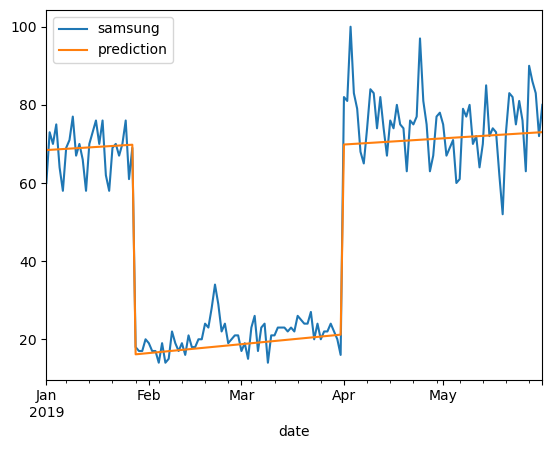

In [23]:

df1 = pd.concat([no_interrupt.iloc[:27], bwn, no_interrupt.iloc[27:]],axis=0)
df1.plot(x = 'date', y = ['samsung','prediction'])


---

const           68.427246
trend            0.052718
interruption   -52.278149
interaction      0.028455
dtype: float64


<AxesSubplot:xlabel='date'>

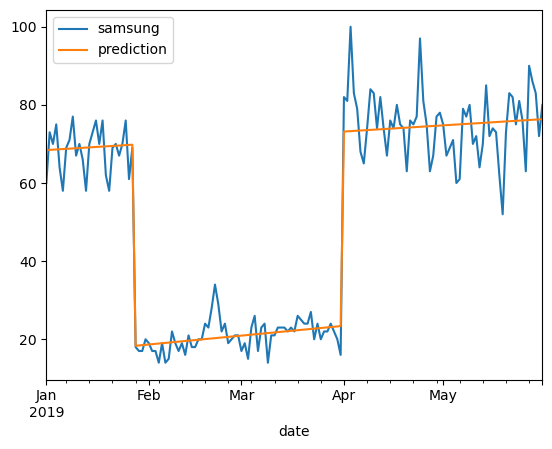

In [24]:
data = df.iloc[:, :3]
data.head(1)

moderator = []
for i in range(27):
    moderator.append(0)
for i in range(90-27):
    moderator.append(1)
for i in range(151-90):
    moderator.append(0)

data['interruption'] = moderator
data['trend'] = data.index
data.head(1)

# 상호작용항 구하기
data['interaction'] = (data.index)*data['interruption']
data.head(1)

x = data[["trend", 'interruption', 'interaction']]
y = data["samsung"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
result = model.fit()
print(result.params)
const_, trend_, interruption_, interaction_ = result.params

# 예측값 구하기
data['prediction'] = [const_ + trend_*data['trend'][n] 
                             + interruption_*data['interruption'][n] 
                             + interaction_*data['interaction'][n]
                      for n in range(len(data))]
data.head(1)
data.plot(x = 'date', y = ['samsung', 'prediction'])

41.693840685706824


<AxesSubplot:xlabel='date'>

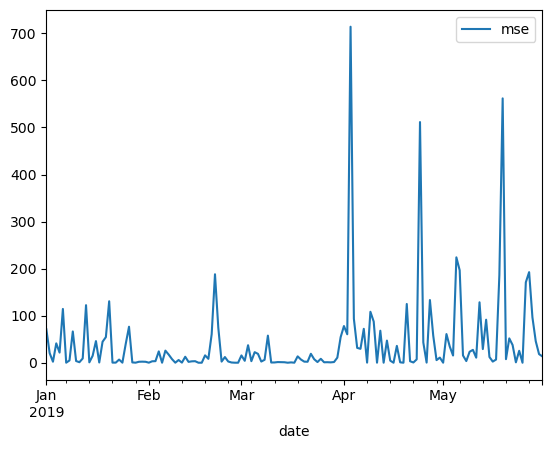

In [25]:
mse = [(s-data['prediction'][num])**2 
       for num, s in enumerate(data['samsung'])]
# 실제값고 예측값의 차이를 제곱한 mse의 값을 리스트화 함
print(np.mean(mse))

data['mse'] = mse
data.plot('date', 'mse')

- 분산이 일정하지 않아 등분산성이 크다는 것을 알 수 있다.
- 어느 시점에서 예측을 잘 못하고 있다는 것인데, 이럴때 synthetic control을 사용한다.
- 그럼 임계값을 어떠헤 구해야할까?

- 대부분의 데이터는 신뢰구간 99.7% 안에 들어있다. (3시그마)
- 여기있는 데이터를 가지고 임계점을 구하면 적절할 것이다.

![image](https://user-images.githubusercontent.com/87592790/203474626-01aa0184-d970-45e6-8469-0e613b11550e.png)


<AxesSubplot:xlabel='date'>

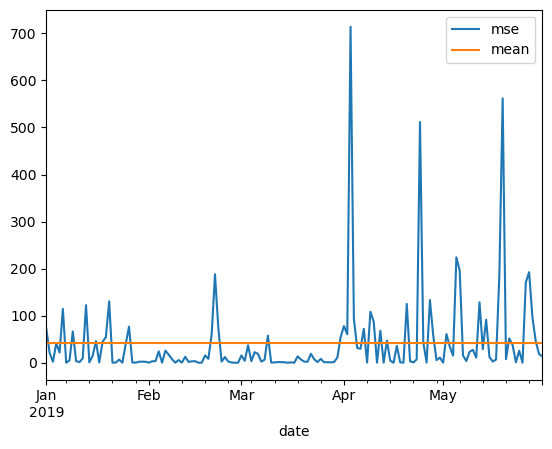

In [39]:
mean_ = np.mean(mse)
data['mean'] = mean_
data.plot(x = 'date', y = ['mse', 'mean'])


<AxesSubplot:xlabel='date'>

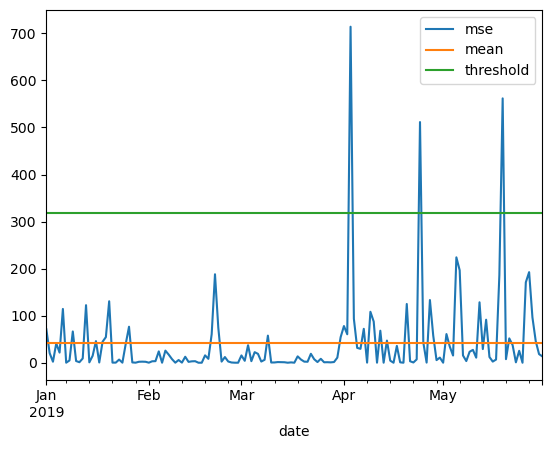

In [38]:

# m + 3∂ 를 구해서 임계점을 정한다.
threshold = mean_ + np.std(mse)*3
data['threshold'] = threshold
data.plot(x='date', y=['mse', 'mean', 'threshold'])

# 슈하트 관리도를 따름, 3계의 임계값을 가진다는 것 알 수 있다.

# 이상치를 갖는 구간을 구해보자.

In [40]:
for num, mse in enumerate(mse):
    if mse > threshold:
        print(num)

92
113
138


In [41]:
print(df.iloc[92]['date']) # 삼성라이온즈 연패를 끊음
print(df.iloc[113]['date']) # 비메모리 반도체에 133조원 투자, 갤럭시탭S 5e출시
print(df.iloc[138]['date']) # 삼성 바이올로직스 분식 회계

# mse를 사용하는 릿지, 라쏘, rnn 등 똑같은 mse를 가지고 확인할 수 있으며
# 알고리즘의 성능이 좋아질수록 설득력있어진다.
# ** 실시간 감지가 가능하다 **
# 

2019-04-03 00:00:00
2019-04-24 00:00:00
2019-05-19 00:00:00
